In [1]:
import torch
import torchsummary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import os

In [2]:
data_path = "drive/MyDrive/data"
save_path = "drive/MyDrive/weight_save"
use_subdata = False

if use_subdata: #코드 검증용으로 일부 데이터만 가져오기

    from torch.utils.data import DataLoader, Subset
    import numpy as np

    transform = transforms.Compose([
        # transforms.Resize(224), # Image net에서는 224 고정인데 cifar는 학습 불안정
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    full_trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
    full_testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)

    subset_indices_train = np.random.choice(len(full_trainset), 32*10, replace=False)
    subset_indices_test = np.random.choice(len(full_testset), 128, replace=False)

    trainset = Subset(full_trainset, subset_indices_train)
    testset = Subset(full_testset, subset_indices_test)

    batch_size = 32
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

else: # 전체 데이터 가져오기
    transform = transforms.Compose(
        [#transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

    batch_size = 64

    trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class NIN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 5, stride=1, padding=2)
        self.cccp1 = nn.Conv2d(in_channels = 96, out_channels = 64, kernel_size = 1, stride=1, padding=0)
        self.cccp2 = nn.Conv2d(in_channels = 64, out_channels = 48, kernel_size = 1, stride=1, padding=0)

        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 128, kernel_size = 5, stride=1, padding=2)
        self.cccp3 = nn.Conv2d(in_channels = 128, out_channels = 96, kernel_size = 1, stride=1, padding=0)
        self.cccp4 = nn.Conv2d(in_channels = 96, out_channels = 64, kernel_size = 1, stride=1, padding=0)

        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 5, stride=1, padding=2)
        self.cccp5 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 1, stride=1, padding=0)
        self.cccp6 = nn.Conv2d(in_channels = 128, out_channels = 10, kernel_size = 1, stride=1, padding=0)

        self.layer_seq = nn.Sequential(self.conv1,
                                       nn.ReLU(),
                                       self.cccc1,
                                       nn.ReLU(),
                                       self.cccc2,
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, stride=2, padding=1),
                                       nn.Dropout(p=0.15),

                                       self.conv2,
                                       nn.ReLU(),
                                       self.cccc3,
                                       nn.ReLU(),
                                       self.cccc4,
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, stride=2, padding=1),
                                       nn.Dropout(p=0.15),

                                       self.conv3,
                                       nn.ReLU(),
                                       self.cccc5,
                                       nn.ReLU(),
                                       self.cccc6,
                                       nn.ReLU(),
                                       torch.nn.AvgPool2d(8, stride=1, padding=0),
                                       nn.Flatten()
                                       )


    def loss(self, label, pred):
        score = F.log_softmax(pred, dim = -1) # -> torch.softmax -> loss nan 문제
        label = F.one_hot(label,num_classes = 10)
        cross_entropy = torch.mean(-torch.sum(label*score, dim = -1))

        return cross_entropy

    def save_weight(self, model, path, epoch):
        file_path = os.path.join(path, f"{epoch}_NIN.pth")
        torch.save(model.state_dict(), file_path)
        print(f"Save Weight at {epoch}")

    def get_feature_maps(self, x):
        fmap1 = self.first_block(x)

        return fmap1

    def forward(self, x):
        x = self.layer_seq(x)

        return x

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = NIN().to(device)
print(torchsummary.summary(model, (3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           7,296
            Conv2d-2           [-1, 96, 32, 32]           7,296
              ReLU-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           6,208
            Conv2d-5           [-1, 64, 32, 32]           6,208
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 48, 32, 32]           3,120
            Conv2d-8           [-1, 48, 32, 32]           3,120
              ReLU-9           [-1, 48, 32, 32]               0
        MaxPool2d-10           [-1, 48, 16, 16]               0
          Dropout-11           [-1, 48, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         153,728
           Conv2d-13          [-1, 128, 16, 16]         153,728
             ReLU-14          [-1, 128,

In [9]:
epoch = 50
optimizer = optim.AdamW(model.parameters(), lr=0.00025)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

train_loss_lst = []
train_accuracy_lst = []
test_loss_lst = []
test_accuracy_lst = []
patience = 0
for iter in range(epoch):
    train_loss = 0.0
    test_loss = 0.0
    train_accuracy_sum = 0
    test_accuracy_sum = 0

    # Training loop
    model.train()
    train_loader = tqdm(trainloader, desc=f"Epoch {iter+1} [Training]", leave=False)
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        best_pred = torch.argmax(outputs, dim = -1)
        correct = (best_pred == labels).sum().item()
        train_accuracy = correct / inputs.shape[0] * 100
        train_accuracy_sum += train_accuracy
        loss = model.loss(labels, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(trainloader)
    train_loss_lst.append(train_loss)

    model.eval()
    test_loader = tqdm(testloader, desc=f"Epoch {iter+1} [Testing]", leave=False)

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            best_pred = torch.argmax(outputs, dim = -1)
            correct = (best_pred == labels).sum().item()
            test_accuracy = correct / inputs.shape[0] * 100
            test_accuracy_sum += test_accuracy
            loss = model.loss(labels, outputs)
            test_loss += loss.item()

    test_loss /= len(testloader)
    test_loss_lst.append(test_loss)

    train_accuracy_mean = train_accuracy_sum / len(trainloader)
    train_accuracy_lst.append(train_accuracy_mean)

    test_accuracy_mean = test_accuracy_sum / len(testloader)
    test_accuracy_lst.append(test_accuracy_mean)

    if iter > 5:
        a = max(test_accuracy_lst[:-2])
        b = test_accuracy_lst[iter]
        print("a = {}, b = {}".format(a, b))
        if (a < b) or (iter%10 == 0):
            model.save_weight(model, save_path, iter)
        elif a >= b:
            patience += 1
            print("참을 인 몇 번? ", patience)

    if patience > 10:
        print("얼~리 스탑!")
        break

    scheduler.step()
    print(f"Epoch [{iter + 1}/{epoch}], Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}, train_acc: {train_accuracy_mean:.3f} %, test_acc: {test_accuracy_mean:.3f} % , Lr: {optimizer.param_groups[0]['lr']}")

print("Training Complete!")



Epoch [1/50], Train Loss: 2.037, Test Loss: 1.887, train_acc: 25.000 %, test_acc: 32.524 % , Lr: 0.00025


Epoch [2/50], Train Loss: 1.764, Test Loss: 1.690, train_acc: 38.663 %, test_acc: 41.650 % , Lr: 0.00025


Epoch [3/50], Train Loss: 1.663, Test Loss: 1.629, train_acc: 43.246 %, test_acc: 44.327 % , Lr: 0.00025


Epoch [4/50], Train Loss: 1.607, Test Loss: 1.563, train_acc: 45.484 %, test_acc: 46.646 % , Lr: 0.00025


Epoch [5/50], Train Loss: 1.554, Test Loss: 1.522, train_acc: 47.554 %, test_acc: 48.199 % , Lr: 0.00025


Epoch [6/50], Train Loss: 1.508, Test Loss: 1.478, train_acc: 49.099 %, test_acc: 49.582 % , Lr: 0.00025


a = 48.198646496815286, b = 51.59235668789809
Save Weight at 6
Epoch [7/50], Train Loss: 1.472, Test Loss: 1.438, train_acc: 50.404 %, test_acc: 51.592 % , Lr: 0.00025


a = 49.58200636942675, b = 51.72173566878981
Save Weight at 7
Epoch [8/50], Train Loss: 1.437, Test Loss: 1.438, train_acc: 51.708 %, test_acc: 51.722 % , Lr: 0.00025


a = 51.59235668789809, b = 53.2046178343949
Save Weight at 8
Epoch [9/50], Train Loss: 1.406, Test Loss: 1.392, train_acc: 52.649 %, test_acc: 53.205 % , Lr: 0.00025


a = 51.72173566878981, b = 53.2046178343949
Save Weight at 9
Epoch [10/50], Train Loss: 1.376, Test Loss: 1.383, train_acc: 53.587 %, test_acc: 53.205 % , Lr: 0.00015


a = 53.2046178343949, b = 54.46855095541401
Save Weight at 10
Epoch [11/50], Train Loss: 1.337, Test Loss: 1.351, train_acc: 55.047 %, test_acc: 54.469 % , Lr: 0.00015


a = 53.2046178343949, b = 54.926353503184714
Save Weight at 11
Epoch [12/50], Train Loss: 1.318, Test Loss: 1.328, train_acc: 55.457 %, test_acc: 54.926 % , Lr: 0.00015


a = 54.46855095541401, b = 55.78224522292994
Save Weight at 12
Epoch [13/50], Train Loss: 1.305, Test Loss: 1.311, train_acc: 55.824 %, test_acc: 55.782 % , Lr: 0.00015


a = 54.926353503184714, b = 55.57324840764331
Save Weight at 13
Epoch [14/50], Train Loss: 1.291, Test Loss: 1.307, train_acc: 56.172 %, test_acc: 55.573 % , Lr: 0.00015


a = 55.78224522292994, b = 56.30971337579618
Save Weight at 14
Epoch [15/50], Train Loss: 1.274, Test Loss: 1.299, train_acc: 56.877 %, test_acc: 56.310 % , Lr: 0.00015


a = 55.78224522292994, b = 56.9765127388535
Save Weight at 15
Epoch [16/50], Train Loss: 1.265, Test Loss: 1.277, train_acc: 57.161 %, test_acc: 56.977 % , Lr: 0.00015


a = 56.30971337579618, b = 56.09076433121019
참을 인 몇 번?  1
Epoch [17/50], Train Loss: 1.251, Test Loss: 1.286, train_acc: 57.479 %, test_acc: 56.091 % , Lr: 0.00015


a = 56.9765127388535, b = 57.14570063694268
Save Weight at 17
Epoch [18/50], Train Loss: 1.242, Test Loss: 1.257, train_acc: 57.605 %, test_acc: 57.146 % , Lr: 0.00015


a = 56.9765127388535, b = 57.05613057324841
Save Weight at 18
Epoch [19/50], Train Loss: 1.227, Test Loss: 1.257, train_acc: 58.298 %, test_acc: 57.056 % , Lr: 0.00015


a = 57.14570063694268, b = 57.17555732484077
Save Weight at 19
Epoch [20/50], Train Loss: 1.215, Test Loss: 1.258, train_acc: 58.444 %, test_acc: 57.176 % , Lr: 8.999999999999999e-05


a = 57.14570063694268, b = 57.464171974522294
Save Weight at 20
Epoch [21/50], Train Loss: 1.194, Test Loss: 1.241, train_acc: 58.989 %, test_acc: 57.464 % , Lr: 8.999999999999999e-05


a = 57.17555732484077, b = 57.55374203821656
Save Weight at 21
Epoch [22/50], Train Loss: 1.187, Test Loss: 1.242, train_acc: 59.247 %, test_acc: 57.554 % , Lr: 8.999999999999999e-05


a = 57.464171974522294, b = 57.58359872611465
Save Weight at 22
Epoch [23/50], Train Loss: 1.181, Test Loss: 1.236, train_acc: 59.449 %, test_acc: 57.584 % , Lr: 8.999999999999999e-05


a = 57.55374203821656, b = 58.190684713375795
Save Weight at 23
Epoch [24/50], Train Loss: 1.174, Test Loss: 1.221, train_acc: 59.731 %, test_acc: 58.191 % , Lr: 8.999999999999999e-05


a = 57.58359872611465, b = 58.29020700636943
Save Weight at 24
Epoch [25/50], Train Loss: 1.166, Test Loss: 1.223, train_acc: 59.777 %, test_acc: 58.290 % , Lr: 8.999999999999999e-05


a = 58.190684713375795, b = 58.24044585987261
Save Weight at 25
Epoch [26/50], Train Loss: 1.161, Test Loss: 1.212, train_acc: 59.956 %, test_acc: 58.240 % , Lr: 8.999999999999999e-05


a = 58.29020700636943, b = 58.578821656050955
Save Weight at 26
Epoch [27/50], Train Loss: 1.156, Test Loss: 1.207, train_acc: 60.034 %, test_acc: 58.579 % , Lr: 8.999999999999999e-05


a = 58.29020700636943, b = 58.6484872611465
Save Weight at 27
Epoch [28/50], Train Loss: 1.147, Test Loss: 1.209, train_acc: 60.372 %, test_acc: 58.648 % , Lr: 8.999999999999999e-05


a = 58.578821656050955, b = 58.66839171974522
Save Weight at 28
Epoch [29/50], Train Loss: 1.143, Test Loss: 1.203, train_acc: 60.462 %, test_acc: 58.668 % , Lr: 8.999999999999999e-05


a = 58.6484872611465, b = 58.49920382165605
참을 인 몇 번?  2
Epoch [30/50], Train Loss: 1.138, Test Loss: 1.216, train_acc: 60.492 %, test_acc: 58.499 % , Lr: 5.399999999999999e-05


a = 58.66839171974522, b = 59.26552547770701
Save Weight at 30
Epoch [31/50], Train Loss: 1.124, Test Loss: 1.196, train_acc: 61.029 %, test_acc: 59.266 % , Lr: 5.399999999999999e-05


a = 58.66839171974522, b = 58.797770700636946
Save Weight at 31
Epoch [32/50], Train Loss: 1.118, Test Loss: 1.186, train_acc: 61.143 %, test_acc: 58.798 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 58.90724522292994
참을 인 몇 번?  3
Epoch [33/50], Train Loss: 1.114, Test Loss: 1.197, train_acc: 61.305 %, test_acc: 58.907 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 59.15605095541401
참을 인 몇 번?  4
Epoch [34/50], Train Loss: 1.114, Test Loss: 1.182, train_acc: 61.355 %, test_acc: 59.156 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 58.797770700636946
참을 인 몇 번?  5
Epoch [35/50], Train Loss: 1.107, Test Loss: 1.195, train_acc: 61.591 %, test_acc: 58.798 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 59.1859076433121
참을 인 몇 번?  6
Epoch [36/50], Train Loss: 1.107, Test Loss: 1.184, train_acc: 61.655 %, test_acc: 59.186 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 59.1062898089172
참을 인 몇 번?  7
Epoch [37/50], Train Loss: 1.102, Test Loss: 1.182, train_acc: 61.509 %, test_acc: 59.106 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 59.195859872611464
참을 인 몇 번?  8
Epoch [38/50], Train Loss: 1.099, Test Loss: 1.185, train_acc: 61.749 %, test_acc: 59.196 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 59.66361464968153
Save Weight at 38
Epoch [39/50], Train Loss: 1.097, Test Loss: 1.175, train_acc: 61.707 %, test_acc: 59.664 % , Lr: 5.399999999999999e-05


a = 59.26552547770701, b = 59.51433121019108
Save Weight at 39
Epoch [40/50], Train Loss: 1.093, Test Loss: 1.183, train_acc: 61.891 %, test_acc: 59.514 % , Lr: 3.2399999999999995e-05


a = 59.66361464968153, b = 59.355095541401276
Save Weight at 40
Epoch [41/50], Train Loss: 1.086, Test Loss: 1.175, train_acc: 62.102 %, test_acc: 59.355 % , Lr: 3.2399999999999995e-05


a = 59.66361464968153, b = 59.59394904458599
참을 인 몇 번?  9
Epoch [42/50], Train Loss: 1.082, Test Loss: 1.172, train_acc: 62.150 %, test_acc: 59.594 % , Lr: 3.2399999999999995e-05


a = 59.66361464968153, b = 59.50437898089172
참을 인 몇 번?  10
Epoch [43/50], Train Loss: 1.080, Test Loss: 1.170, train_acc: 62.252 %, test_acc: 59.504 % , Lr: 3.2399999999999995e-05


a = 59.66361464968153, b = 59.47452229299363
참을 인 몇 번?  11
얼~리 스탑!
Training Complete!


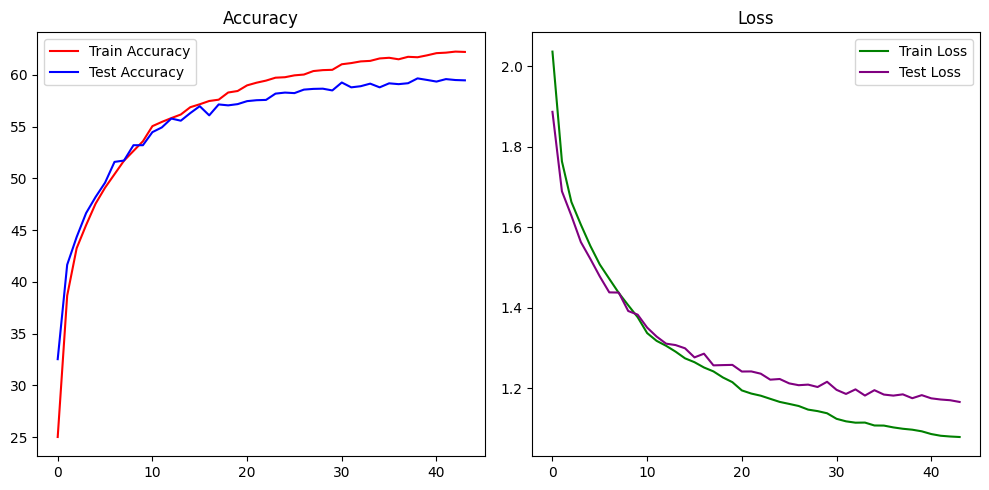

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_lst, 'r', label="Train Accuracy")
plt.plot(test_accuracy_lst, 'b', label="Test Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_loss_lst, 'g', label="Train Loss")
plt.plot(test_loss_lst, 'purple', label="Test Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()